# Handwritten russian letters classification system

--- 

**Summary** :   
This notebook aims to create an engine capable to automatically classify an image of a handwritten letter into one of 33 categories/letters of Russian alphabet using the deep learning technologies.


**Data source** :    

The dataset is publicy available on Kaggle here : 
https://www.kaggle.com/tatianasnwrt/russian-handwritten-letters

The dataset includes a folder with the total of 14190 PNG format images. It also has a csv file describing each image. This information file contains 4 columns:

- letter (in cyrillic);
- file (the name of a file with this image);
- label (a number corresponding to that letter, see below);

        а=>1, б=>2, в=>3, г=>4, д=>5, е=>6, ё=>7, ж=>8, з=>9, и=>10, й=>11, к=>12, л=>13, м=>14, н=>15, о=>16, п=>17, р=>18, с=>19, т=>20, у=>21, ф=>22, х=>23, ц=>24, ч=>25, ш=>26, щ=>27, ъ=>28, ы=>29, ь=>30, э=>31, ю=>32, я=>33

- background (a label corresponding to the background of an image, see below).

        striped=>0
        gridded=>1
        no background=>2
        graph paper=>3

**Notebook structure** 

This Notebook has 4 main parts:
- Exploratory Data Analysis
- Data Preparation
- Model Creation
- Model Evaluation 

# 1.Exploratory Data Analysis

#### 1.1 Setup

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from sklearn import metrics 
from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

#### 1.2. Load the dataset : Handwritten Russian Letters

In [64]:
# csv_path : csv file describing each image.  
# images_dir_path : location of directory with the total of 14190 PNG format images.

csv_path = 'data\\all_letters_info.csv'
images_dir_path = 'data\\all_letters_image'

In [65]:
csv_df = pd.read_csv(csv_path)

#### 1.3. Explore the images describing csv file

In [6]:
csv_df.columns

Index(['letter', 'label', 'file', 'background'], dtype='object')

In [7]:
csv_df.head(5)

,letter,label,file,background
0,а,1,01_01.png,0
1,а,1,01_02.png,0
2,а,1,01_03.png,0
3,а,1,01_04.png,0
4,а,1,01_05.png,0


In [8]:
# Letters number
print('Letters number : ', len(csv_df['letter'].value_counts()))
# All letters 
print('All letters  : ', csv_df['letter'].unique(), '\n')
# Labels number
print('Labels number : ', len(csv_df['label'].value_counts()))
# All Labels 
print('All labels  : ', csv_df['label'].unique(), '\n')
# Background number
print('Background labels number : ', len(csv_df['background'].value_counts()))
# All backgrounds 
print('All background labels  : ', csv_df['background'].unique(), '\n')
# Files number
print('Files number : ', len(csv_df['file']), '\n')

Letters number :  33
All letters  :  ['а' 'б' 'в' 'г' 'д' 'е' 'ё' 'ж' 'з' 'и' 'й' 'к' 'л' 'м' 'н' 'о' 'п' 'р'
 'с' 'т' 'у' 'ф' 'х' 'ц' 'ч' 'ш' 'щ' 'ъ' 'ы' 'ь' 'э' 'ю' 'я'] 

Labels number :  33
All labels  :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] 

Background labels number :  4
All background labels  :  [0 1 2 3] 

Files number :  14190 



<AxesSubplot:xlabel='letter', ylabel='Count'>

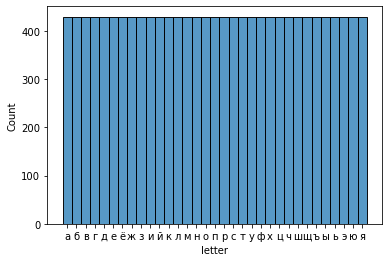

In [9]:
# Check wheter the target classes are well balanced -> they are all perfectly balanced, see hist below. 

sns.histplot(data = csv_df, x = "letter")

<AxesSubplot:xlabel='count', ylabel='background'>

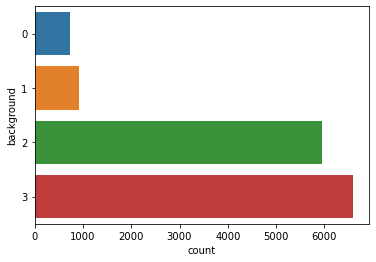

In [10]:
# Check the feature 'background' distribution -> it's not well balanced, there is a big gap between \
# the 0, 1 and 2,3 types backgrounds.

sns.countplot(y="background", data=csv_df)

<AxesSubplot:xlabel='letter', ylabel='Count'>

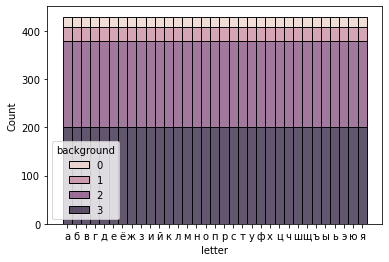

In [11]:
# Check how the feature 'background' is distributed along each target class -> each letter is 
# represented by the same amount of images with the same background type distribution. 

sns.histplot(data = csv_df, x = "letter", hue = 'background', multiple = "stack")

In [12]:
labels = csv_df['label']
letters = csv_df['letter']
backgrounds = csv_df['background']
files = csv_df['file']

##### 1.4. Explore image files 

In [13]:
def map_backgrounds(to_map : int) -> str:
  ''' Map background labels'''

  if to_map == 0:
    return 'striped'
  elif to_map == 1:
    return 'gridded'
  elif to_map == 2:
    return 'no background'
  else:
    return 'graph paper'

def map_labels(df : pd.DataFrame, to_map : int) -> str:
    ''' Map letter labels'''
    
    mapped = 'mapping_error'
    letters_unique = df['letter'].unique()
    labels_unique = df['label'].unique()
    for i, label in enumerate(labels) : 
        if label - 1 == to_map: 
            mapped = letters[i]

    return mapped 

def img_to_array(img_dir_path, img_names : list) -> list: 
    ''' Convert img to array 
    Out : list of arrays '''
    
    list_ = []
    
    # TODO : find more sophisticated way to define the path (now it'll not work for linux)
    
    for img_name in img_names: 
        img_path = img_dir_path + '\\' + img_name
        img_arr = cv2.imread(img_path)
        list_.append(img_arr)
        
    return list_

def display_imgs(images :list, min_per_row :int, size :int, bg_index : int = 0, displayBackgroundLabel = False) -> None:
    ''' Display images with their background labels '''
    
    n_images = len(images)
    images_per_row = min(n_images, min_per_row)
    fig = plt.figure(figsize = (size, size))
    
    for i, image in enumerate(images, start = bg_index):
        fig.add_subplot(images_per_row, np.ceil(n_images/float(images_per_row)), i + 1 - bg_index)
        plt.imshow(image)
        
        if displayBackgroundLabel:
            background_label = map_backgrounds(backgrounds[i])
            plt.xlabel(background_label)
        plt.xticks([]), plt.yticks([])

    plt.show()

In [14]:
# Some ranges of image indexes with different backgrounds.  

background_stripped_gridded = list(range(0,100))
background_no_background = list(range(7000,7100))
background_graph_paper = list(range(14000,14100))

C:\Users\nasti\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


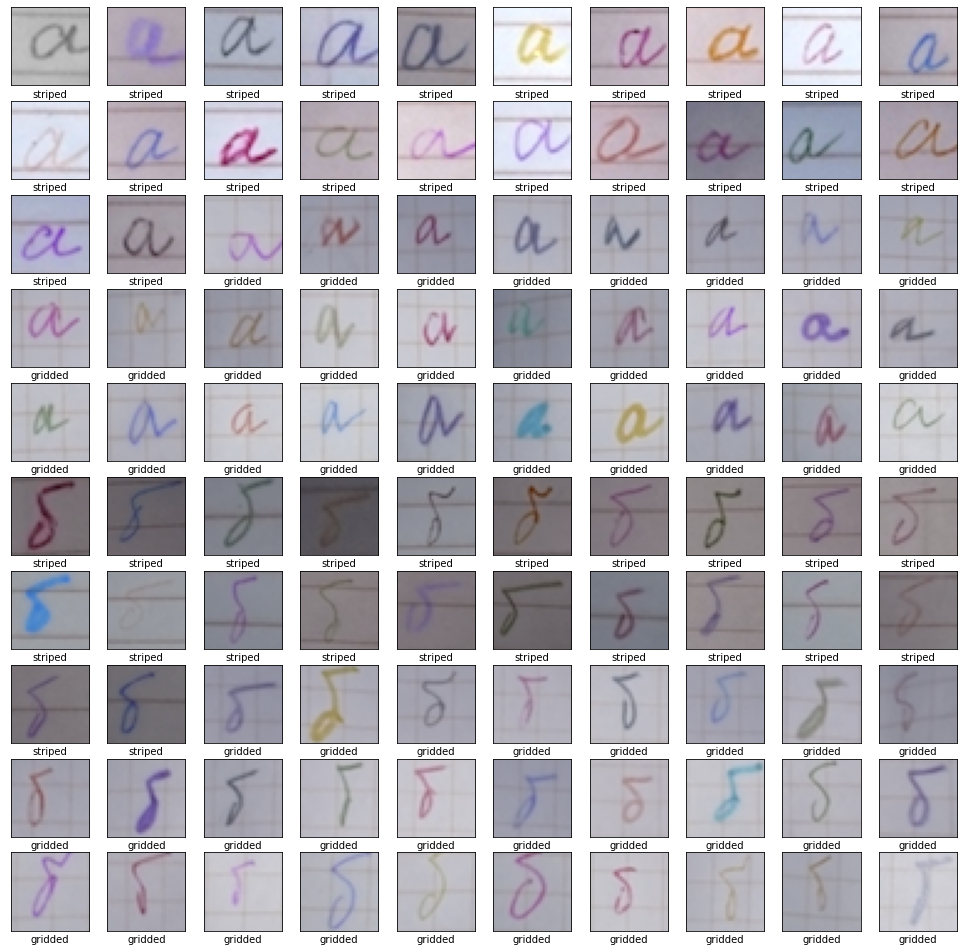

In [16]:
# Display images with stripped and gridded backgrounds 

img_names = files[background_stripped_gridded]
img_arrs = img_to_array(images_dir_path, img_names)
display_imgs(img_arrs, 10, 17, backgrounds[background_stripped_gridded[0]], True)

C:\Users\nasti\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


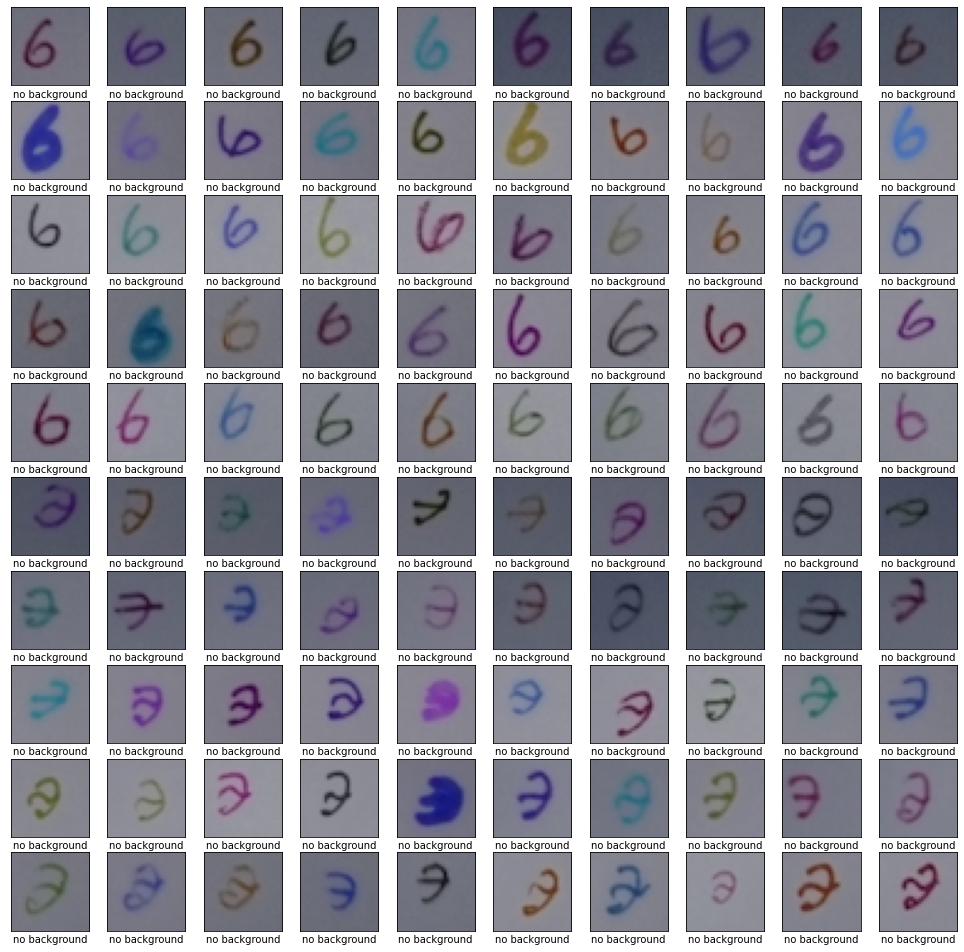

In [18]:
# Display images with no background

IMG_NAMES = files[background_no_background]
img_arrs = img_to_array(images_dir_path, IMG_NAMES)
display_imgs(img_arrs, 10, 17, background_no_background[0], True)

C:\Users\nasti\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


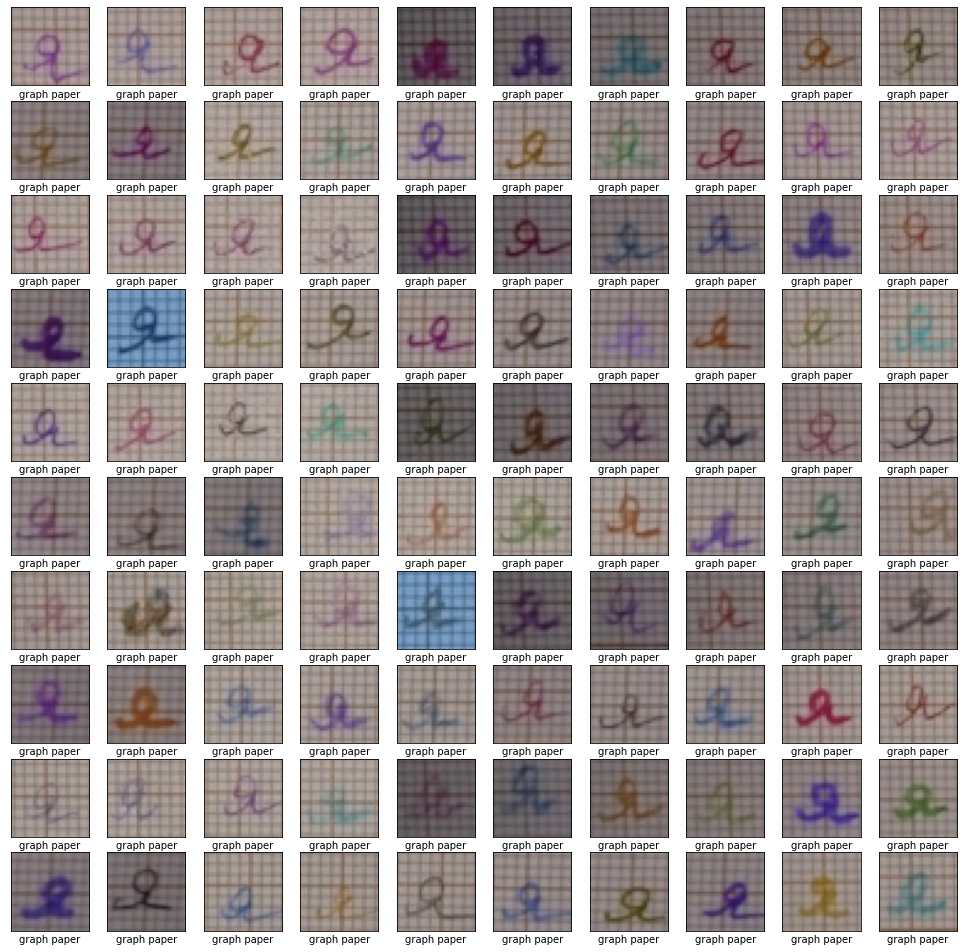

In [19]:
# Display images with Graph Paper Background

IMG_NAMES = files[background_graph_paper]
img_arrs = img_to_array(images_dir_path, IMG_NAMES)
display_imgs(img_arrs, 10, 17, background_graph_paper[0], True)

#####  Conclusion : 

- All target values are well distributed. 
- No malformed features detected. 
- The images backgrounds are poorly distributed. For exemple the number of images with  background type 'stripped' and 'gridded' is ~ 6 times lesser than 'graph paper' and 'no background'. 
- The presence of different background types can reduce model performances. We suggest to eliminate the noise, applying different strategies according to the image background type. 

Next section contains the data preparation and background noises detection part. We will pay special attention to the cleaning of the images with 'no background' and 'graph paper' background types.  


# 2. Dataset Preparation

In [20]:
# Basic image transformation functions

def resize(image : np.ndarray) -> np.ndarray:
    ''' Resize image'''
    dsize = (32, 32)
    return cv2.resize(image, dsize)

def get_grayscale(image : np.ndarray) -> np.ndarray:
    ''' Grayscale image'''
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding(image : np.ndarray, thresh_tup : tuple ) -> np.ndarray:
    ''' Keep precise range of image pixels'''
    return cv2.threshold(image, thresh_tup[0], thresh_tup[1], cv2.THRESH_TOZERO_INV)[1]

def remove_strokes_vert(image : np.ndarray, thres : int) -> np.ndarray:
    '''Remove vertical background strokes '''
    shape = 32
            
    for i in range(shape):
        if np.count_nonzero(image[:,i] != 0) > thres:
            image[:,i] = np.where(image[:,i] != 0, 0, image[:,i])

    return image

def remove_strokes_horiz(image : np.ndarray, thres : int) -> np.ndarray:
    '''Remove horizontal background strokes '''
    shape = 32

    for i, dim in enumerate(image):
        if np.count_nonzero(dim != 0) > thres:
            dim = np.where(dim != 0, 0, dim)
            image[i] = dim
    return image

def dilate(image : np.ndarray, thresh : int) -> np.ndarray:
    ''' Increase target object area '''
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, thresh)
    return cv2.dilate(image,kernel,iterations = 1)

def denoise(image : np.ndarray, thresh : int) -> np.ndarray:
    ''' Delete background noises '''
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    img2 = image

    for i in range(0, nb_components):
        if sizes[i] < thresh:
            img2[output == i + 1] = 0

    return img2 

In [21]:
# Image transformation functions regroupped according to the background type of the image 

def transform_graph_paper(image : np.ndarray) -> np.ndarray: 
    '''Transform images with graph paper background'''
    
    THRESH_THRESH = 13
    CLEAN_THRESH = 28
    DIL_THRESH = (2,2)
    DEN_THRESH = 15
    CLOS_THRESH = np.ones((1,2),np.uint8)
    
    img_resized = resize(image) 
    gray = get_grayscale(img_resized)
    dst = cv2.GaussianBlur(gray,(3,3),0)
    thresh = thresholding(dst, (np.percentile(dst, THRESH_THRESH), np.max(dst)))
    clean = remove_strokes_horiz(thresh, CLEAN_THRESH)
    clean = remove_strokes_vert(clean, CLEAN_THRESH)
    denoised = denoise(clean, DEN_THRESH)
    dilation = dilate(denoised, DIL_THRESH)
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, CLOS_THRESH)
    closing = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY_INV)[1]
    
    return (closing)

def transform_no_bg(image : np.ndarray) -> np.ndarray:
    '''Transform images with no background'''
        
    THRESH_THRESH = 17
    DIL_THRESH = (1,2)
    DEN_THRESH = 100
    CLOS_THRESH = np.ones((1,2),np.uint8)
    kernel = np.ones((3,3),np.float32)/25
    
    img_resized = resize(image) 
    gray = get_grayscale(img_resized)
    dst = cv2.GaussianBlur(gray,(3,3),0)
    thresh = thresholding(dst, (np.percentile(dst, THRESH_THRESH), np.max(dst)))
    denoised = denoise(thresh, DEN_THRESH)
    closing = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, CLOS_THRESH)
    closing = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY_INV)[1]
    
    return closing

def transform_stripped(image : np.ndarray) -> np.ndarray:
    '''Transform images with stripped background'''
    
    THRESH_THRESH = 25
    CLEAN_THRESH = 20
    DIL_THRESH = (1,2)
    DEN_THRESH = 15
    CLOS_THRESH = np.ones((1,3),np.uint8)
    kernel = np.ones((1,1),np.float32)/25
    
    img_resized = resize(image) 
    gray = get_grayscale(img_resized)
    dst = cv2.GaussianBlur(gray,(3,3),0)
    thresh = thresholding(dst, (np.percentile(dst, THRESH_THRESH), np.max(dst)))
    clean = remove_strokes_horiz(thresh, CLEAN_THRESH)
    denoised = denoise(clean, DEN_THRESH)
    erosion = cv2.erode(denoised, kernel,iterations = 1)
    dilation = dilate(erosion, DIL_THRESH)
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, CLOS_THRESH)
    closing = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY_INV)[1]
    
    return (closing)

def transform_gridded(image : np.ndarray) -> np.ndarray:
    '''Transform images with gridded background'''
    
    THRESH_THRESH = 15
    CLEAN_THRESH = 20
    DIL_THRESH = (1,2)
    DEN_THRESH = 15
    CLOS_THRESH = np.ones((1,3),np.uint8)
    kernel = np.ones((1,1),np.float32)/25
    
    img_resized = resize(image) 
    gray = get_grayscale(img_resized)
    dst = cv2.GaussianBlur(gray,(3,3),0)
    thresh = thresholding(dst, (np.percentile(dst, THRESH_THRESH), np.max(dst)))
    clean = remove_strokes_horiz(thresh, CLEAN_THRESH)
    denoised = denoise(clean, DEN_THRESH)
    dilation = dilate(denoised, DIL_THRESH)
    closing = cv2.threshold(dilation, 0, 255, cv2.THRESH_BINARY_INV)[1]
    
    return (closing)
    

In [22]:
# Functions performing the entire dataset preparation and normalization 

def normalize_data(data : np.ndarray, density : int) -> np.ndarray: 
    '''Normalize the data'''
    
    data = data.astype('float32')
    data = data / 255.0
    data = data.reshape(-density, 32, 32, density)
    return data
    
def resize_data(data : list) -> np.ndarray: 
    ''' Resize the data '''
    
    data = [resize(x) for x in data]
    data = np.reshape(data, (-1, 1024))
    data = data.reshape(int(len(data)/3), 3072 )
    data = normalize_data(data, 3)

    return data

def grayscale_data(data : list) -> np.ndarray:
    '''Resize and grayscale the data'''
    
    data = [resize(x) for x in img_arrs]
    data = [get_grayscale(x) for x in data]
    data = np.reshape(data, (-1, 1024))
    data = normalize_data(data, 1)
    
    return data

def full_data_preparation(data : list) -> np.array:
    '''Apply all available image transformations on data'''
    list_ = []
    
    for i, image in enumerate(data):
        
        background_value = map_backgrounds(backgrounds[i])
        
        if background_value == 'graph paper':
            img_transformed = transform_graph_paper(image)

            list_.append(img_transformed)
            
        elif background_value == 'no background':
            img_transformed = transform_no_bg(image)
            list_.append(img_transformed)
        
        elif background_value == 'gridded':
            img_transformed = transform_gridded(image)
            list_.append(img_transformed)
    
        else :
            img_transformed = transform_stripped(image)
            list_.append(img_transformed)

    full_prepared_data = np.concatenate(list_)
    full_prepared_data = np.reshape(full_prepared_data, (-1, 1024))
    full_prepared_data = normalize_data(full_prepared_data, 1)
    
    return full_prepared_data

In order to compare how background noise detection influences the model performances, we will prepare 
three transformed datasets : 
- dataset with only image resizing
- dataset with resizing and grayscaling  
- full prepared dataset will all background noises detection and elimination 

In [24]:
RANGE = list(range(0, len(files)))
img_names = files[RANGE]
img_arrs = img_to_array(images_dir_path, img_names)

resized_prepared_data = resize_data(img_arrs)
grayscaled_prepared_data = grayscale_data(img_arrs)
full_prepared_data = full_data_preparation(img_arrs)

print('Data resized and normalized shape :', resized_prepared_data.shape)
print('Data resized, grayscaled and normalized shape :', grayscaled_prepared_data.shape)
print('Data full prepared shape :', full_prepared_data.shape)

Data resized and normalized shape : (14190, 32, 32, 3)
Data resized, grayscaled and normalized shape : (14190, 32, 32, 1)
Data full prepared shape : (14190, 32, 32, 1)


Now we have 3 prepared datasets : original, grayscaled and full transformed.

Below are som images from transformes dataset. We can see that images with no background are well processed. However those with background stripped, gridded and graph paper have more noise.

C:\Users\nasti\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


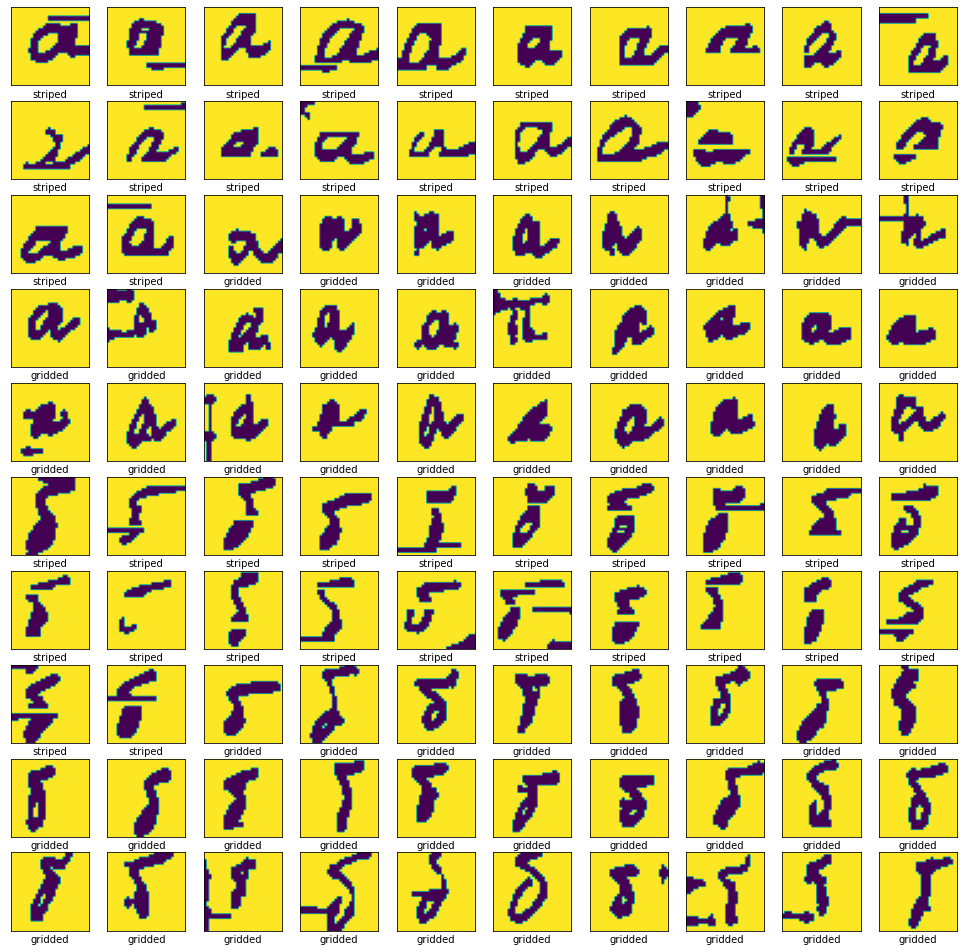

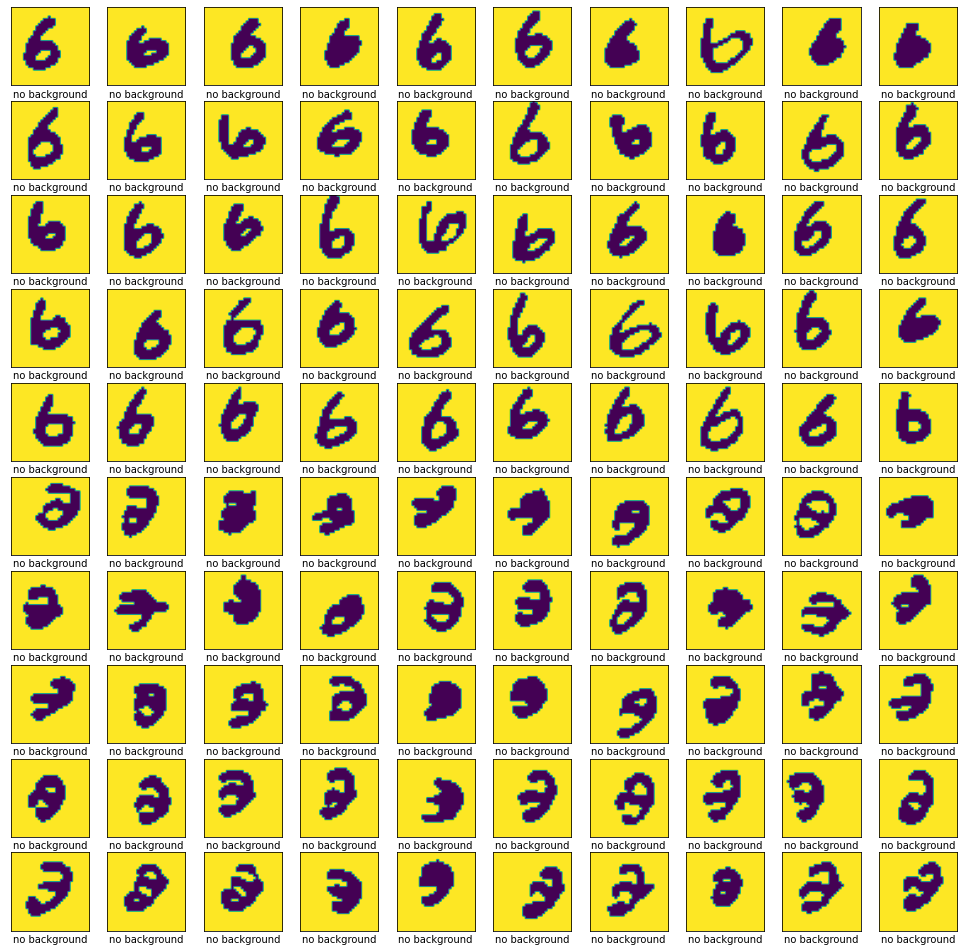

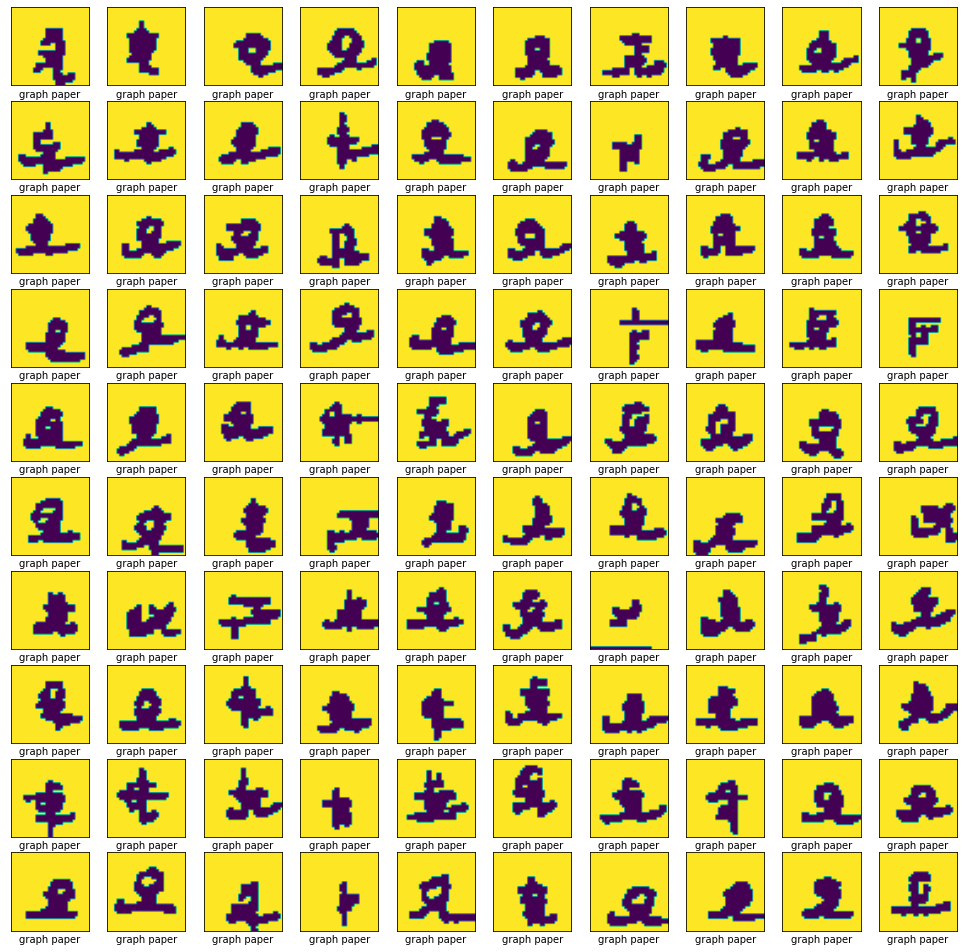

In [25]:
display_imgs(full_prepared_data[background_stripped_gridded], 10, 17, background_stripped_gridded [0],True)
display_imgs(full_prepared_data[background_no_background ], 10, 17, background_no_background [0], True)
display_imgs(full_prepared_data[background_graph_paper], 10, 17,background_graph_paper [0], True)

In [26]:
# One hot encoding of target values

y = labels
y = keras.utils.to_categorical(y-1, 33)
print(y.shape)

(14190, 33)


# 3. Model creation

In [27]:
def fit_datagen(X : np.ndarray) -> ImageDataGenerator : 
    ''' Perform automatic data augmentaiton '''
    datagen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range=0.2,
        height_shift_range=0.2)
    datagen.fit(X)
    
    return datagen

In [37]:
def train_model (X : np.ndarray, y : np.ndarray, density : int, dataset_type_suffix : str) -> (keras.callbacks.History, tuple, tuple): 
    ''' Split the dataset, create and train the model '''
    
    X_whole, X_val, y_whole, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=0)
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding="same", activation="relu", input_shape=(32,32,density)))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding="same", activation="relu", input_shape=(32,32,density)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(33, activation="softmax"))

    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience = 3, min_lr=0.001)
    
    es = EarlyStopping(monitor='val_acc', mode='max', verbose = 1, patience = 50)
    mc = ModelCheckpoint(f'best_{dataset_type_suffix}_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    datagen = fit_datagen(X_train)
    history = model.fit(datagen.flow(X_train, y_train, batch_size = 70), epochs = 100 , validation_data = (X_val, y_val), callbacks = [reduce_lr, es, mc])
    
    return history, (X_test, y_test), (X_val, y_val)

In [ ]:
history_res, data_test_res, data_val_res  = train_model(resized_prepared_data , y, 3, 'res')
history_gray,  data_test_gray, data_val_gray = train_model(grayscaled_prepared_data  , y, 1, 'gray')
history_full, data_test_full, data_val_full = train_model(full_prepared_data , y, 1, 'full')

# 4. Model evaluation

In [39]:
def plot_history(history : keras.callbacks.History , title : str = '') -> None:
    ''' Plot history of Keras model : accuracy, loss, validation accuracy and validation loss '''
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title(title)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('')
    plt.legend()


In [44]:
model_res = load_model('best_res_model.h5')
model_gray = load_model('best_gray_model.h5')
model_full = load_model('best_full_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [45]:
_, valid_acc_res = model_res.evaluate(data_val_res[0], data_val_res[1], verbose=0)
_, valid_acc_gray = model_gray.evaluate(data_val_gray[0], data_val_gray[1], verbose=0)
_, valid_acc_full = model_full.evaluate(data_val_full[0], data_val_full[1], verbose=0)

print('Validaiton accuracy on resized dataset : ', valid_acc_res)
print('Validaiton accuracy on resized and grayscaled dataset : ', valid_acc_gray)
print('Validaiton accuracy on fully transformed dataset : ',valid_acc_full)

Validaiton accuracy on resized dataset :  0.931642
Validaiton accuracy on resized and grayscaled dataset :  0.92741364
Validaiton accuracy on fully transformed dataset :  0.8206484


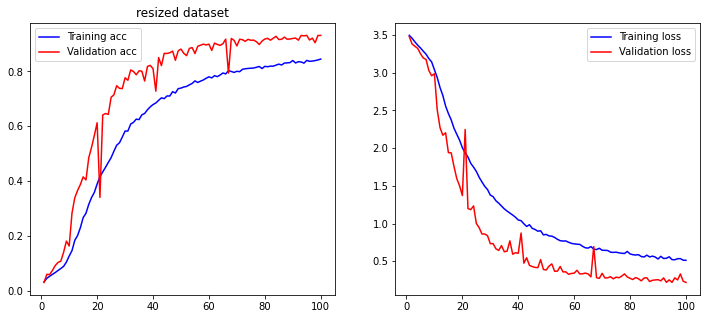

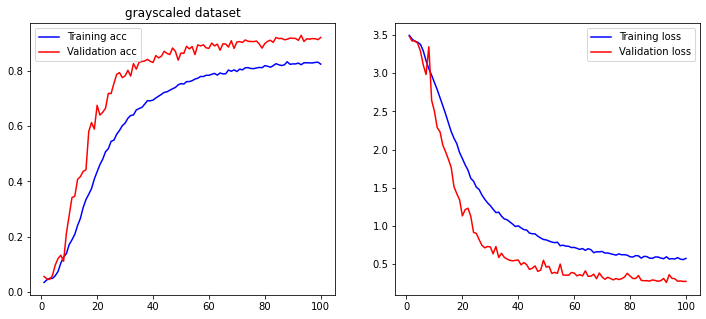

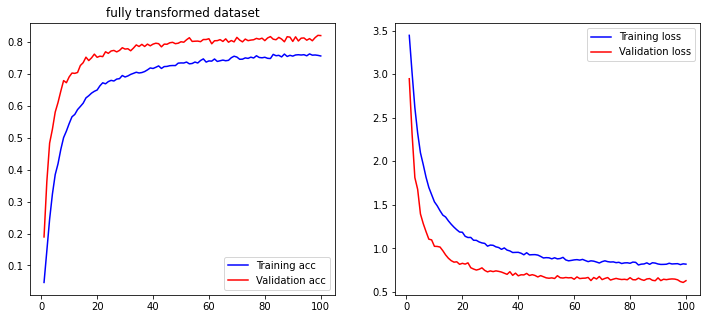

In [46]:
plot_history(history_res, 'resized dataset')
plot_history(history_gray, 'grayscaled dataset')
plot_history(history_full, 'fully transformed dataset')

# Conslusion :

The model 'model_res' is trained on the dataset without any important transformations (only image resizing was applyied). It has the better accuracy score on validation set : 0,931

The model 'model_gray' is trained on the grayscaled dataset and have a slightly worse performance : 0,927. The original handwritten letters are written in different colors. This feature was probably used by the 'model_res' and deleted by grayscaling transformation, explaining 'model_gray' model degradation.

The model 'model_full' is trained on fully prepared dataset and has the worst score : 0.82. However, this model converges faster than former two models. Thus, the image full preprocessing helped the model to quickly find patterns, but the presence of noise worsened the results. 

In [53]:
model, history, data_test  = model_res, history_res, data_test_res

X_test = data_test[0]
y_test = data_test[1]

#### Predictions on the test data

In [49]:
def display_errors(df : pd.DataFrame, X : np.ndarray, y : np.ndarray, y_pred : np.ndarray, 
                   true_val : int, false_val : int, size : int, min_per_row ) -> None:
    ''' Display errors '''
    
    X = X[(y == true_val) & (y_pred == false_val)]
    n_images = len(X)
    images_per_row = min(len(X), min_per_row)
    fig = plt.figure(figsize = (size, size))
    
    for i, image in enumerate(X):
        fig.add_subplot(images_per_row, np.ceil(n_images/float(images_per_row)), i + 1 )
        plt.imshow(image)
        plt.xlabel(f'{map_labels(df, true_val)} -> {map_labels(df, false_val)}')
        plt.xticks([]), plt.yticks([])

    plt.show()

In [54]:
# Model Accuracy on the test data

_, test_acc = model_res.evaluate(X_test, y_test, verbose=0)
print(f'Model accuracy on test set: {test_acc}')

Model accuracy on test set: 0.9321884512901306


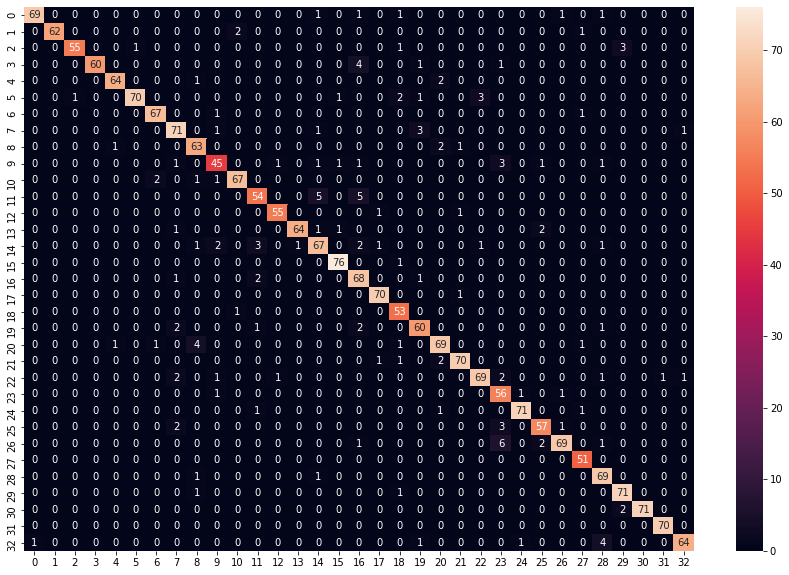

In [55]:
# Plot the confusion matrix 

pred = model.predict_classes(X_test)
y_test = np.argmax(y_test, axis=1)
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize = (15,10))
sns.heatmap(cm,annot=True)
plt.show()

Conclusion : the confusion matrix demonstrate some the ofthen confused pairs of labels.
 
We'll visualise and analyze them below. 

C:\Users\nasti\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


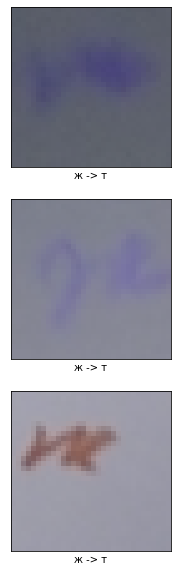

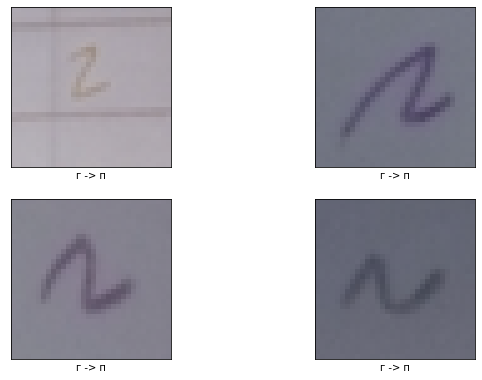

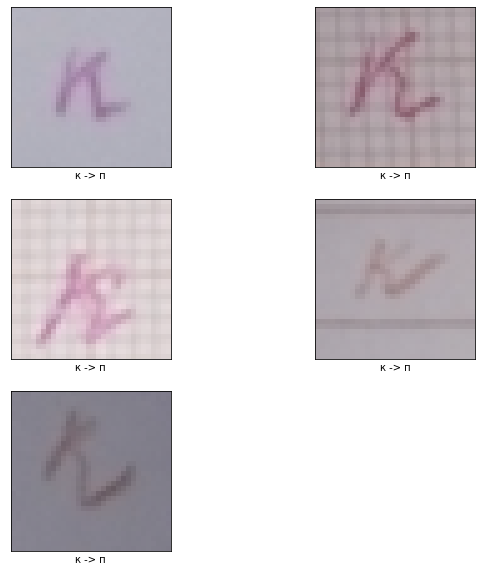

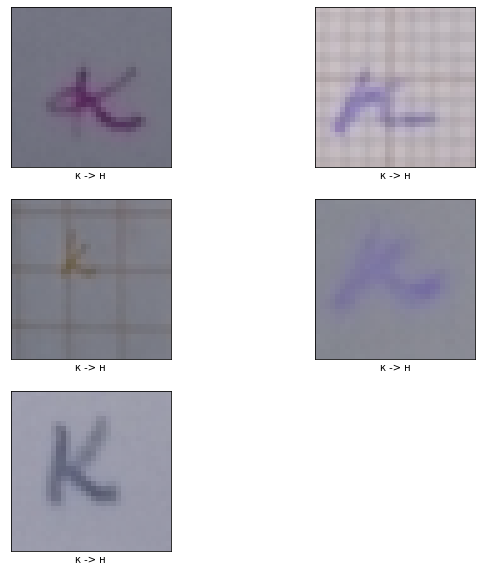

In [61]:
# Visualise some errors -> most of the erros can be done by the human.

values = [(7, 19), (3, 16), (11, 16), (11, 14)]

for value in values : 

    true_val = value[0]
    false_val = value[1]
    display_errors(csv_df, X_test, y_test, pred, true_val, false_val, 10, 3)

# Conclusion 

We've performed automatic russian handwritten caracters recognition using CNN neural network.
The used dataset includes 14190 png images of handwritten russian letters. The data was split as following :   
  
Train set = 80%  
Validation set = 10%  
Test set = 10%  


We've achieved 93% accuracy on the test set using the model trained with 100 epocs.   

The model makes mistakes mostly in those cases  where a human eye would've probably guessed wrong as well. 

In order to improve model performance and reduce training time, it's possible to improve image background noises detection. 